# Forecast analysis

In [139]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from enum import Enum
from ngboost.scores import LogScore
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from ngboost.distns import Exponential, Normal, LogNormal
from ngboost.scores import LogScore, CRPScore
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import ephem
from datetime import datetime
import pickle
from pathlib import Path
import pypsa

paths = {"era5_eu_2013": "resources/europe-2013-era5.nc",
         "era5_tutorial": "resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "resources/capfacs_37.csv",
         "era5_regions": "resources/europe-2013-era5-regions.nc",
         "res_pypsa_q40": "results/drive-download-20220711T131911Z-001/capfacts_pred_q40_clipped.csv",
         "res_pypsa_q60": "resources/pypsa/results/networks/elec_s_37_q60_ec_lv1.0_Co2L0.0-1H.nc",
         "res_pypsa_qo": "resources/pypsa/results/networks/elec_s_37_qo_ec_lv1.0_Co2L0.0-1H.nc"}

In [29]:
ds = xr.open_dataset(filename_or_obj=paths["era5_regions"], engine="netcdf4")
capfacts = pd.read_csv(paths["capfacs"])
capfacts_pred_q40 = pd.read_csv("results/capfacts_pred_q40.csv", index_col=0)
capfacts_pred_q40_clipped = pd.read_csv("results/capfacts_pred_q40_clipped.csv", index_col=0)
capfacts_pred_q60 = pd.read_csv("results/capfacts_pred_q60.csv", index_col=0)
capfacts_pred_q60_clipped = pd.read_csv("results/capfacts_pred_q60_clipped.csv", index_col=0)

In [30]:
def coverage_fraction(y, y_low, y_high):
    """
    :param y:
    :param y_low:
    :param y_high:
    :return:
    """
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

In [31]:
capfacts

,snapshot,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,...,SE4 0 onwind,SE4 0 ror,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 ror,SI0 0 solar,SK0 0 onwind,SK0 0 ror,SK0 0 solar
0,2013-01-01 00:00:00,0.003291,0.001469,0.0,0.163262,0.224456,0.0,0.007340,0.0,1.000000,...,0.459609,0.626955,0.0,0.000000,0.055146,0.344668,0.0,0.361009,0.106197,0.0
1,2013-01-01 01:00:00,0.002103,0.000000,0.0,0.171340,0.224369,0.0,0.007939,0.0,0.999998,...,0.463265,0.625502,0.0,0.000000,0.052605,0.344657,0.0,0.368912,0.106012,0.0
2,2013-01-01 02:00:00,0.000000,0.000000,0.0,0.171035,0.224300,0.0,0.007829,0.0,0.993941,...,0.463777,0.624810,0.0,0.000000,0.052222,0.344593,0.0,0.382949,0.105968,0.0
3,2013-01-01 03:00:00,0.000000,0.000000,0.0,0.169685,0.224249,0.0,0.005766,0.0,0.916094,...,0.463041,0.623794,0.0,0.000000,0.050762,0.344626,0.0,0.388344,0.106215,0.0
4,2013-01-01 04:00:00,0.000000,0.000000,0.0,0.159757,0.224213,0.0,0.004262,0.0,0.704786,...,0.457253,0.623085,0.0,0.000000,0.047285,0.344607,0.0,0.409303,0.106364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.029235,0.024321,0.0,0.109127,0.275353,0.0,0.001076,0.0,0.998922,...,0.358191,0.469586,0.0,0.027877,0.001708,0.696975,0.0,0.125735,0.157729,0.0
8756,2013-12-31 20:00:00,0.034024,0.031357,0.0,0.120485,0.275159,0.0,0.001090,0.0,0.965757,...,0.324709,0.469395,0.0,0.023567,0.000000,0.696262,0.0,0.142431,0.157817,0.0
8757,2013-12-31 21:00:00,0.037104,0.034522,0.0,0.128186,0.274975,0.0,0.001062,0.0,0.852484,...,0.288415,0.469208,0.0,0.000000,0.004891,0.695524,0.0,0.153930,0.157899,0.0
8758,2013-12-31 22:00:00,0.029730,0.027419,0.0,0.124740,0.274784,0.0,0.001351,0.0,0.776442,...,0.268695,0.469028,0.0,0.000000,0.009091,0.694665,0.0,0.163442,0.157945,0.0


In [36]:
regions = capfacts_pred_q40.columns.values[1:]

idx_names = ["real_mean", "q40_mean", "q40_clipped_mean","q60_mean", "q60_clipped_mean", "20% confidence"]
idx = dict(zip(idx_names, idx_names))
capfacts_analysis = pd.DataFrame(index = idx)

new_columns = {}

for region in regions:
    values = {}
    values[idx["real_mean"]] = capfacts[region].mean()
    values[idx["q40_mean"]] = capfacts_pred_q40[region].mean()
    values[idx["q60_mean"]] = capfacts_pred_q40[region].mean()
    values[idx["q40_clipped_mean"]] = capfacts_pred_q40_clipped[region].mean()
    values[idx["q60_clipped_mean"]] = capfacts_pred_q60_clipped[region].mean()
    values[idx["20% confidence"]] = coverage_fraction(capfacts[region], capfacts_pred_q40[region], capfacts_pred_q60[region])

    new_columns[region] = pd.Series(values)

new_columns = pd.DataFrame(new_columns, index=capfacts_analysis.index)
capfacts_analysis = pd.concat([capfacts_analysis, new_columns], axis = 1)
capfacts_analysis

,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,BE0 0 offwind-dc,BE0 0 onwind,...,RS0 0 solar,SE4 0 offwind-ac,SE4 0 offwind-dc,SE4 0 onwind,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 solar,SK0 0 onwind,SK0 0 solar
real_mean,0.144222,0.059075,0.131122,0.133949,0.102517,0.047873,0.113904,0.461893,0.520243,0.290474,...,0.116954,0.411495,0.497266,0.221257,0.095503,0.127760,0.057465,0.106495,0.142276,0.104567
q40_mean,0.135868,0.053726,0.120950,0.125559,0.094300,0.044585,0.105111,0.451567,0.509520,0.282439,...,0.108525,0.394833,0.468410,0.211098,0.086383,0.126285,0.054406,0.097238,0.131129,0.096594
q40_clipped_mean,0.135872,0.053739,0.121467,0.125564,0.094621,0.044585,0.105734,0.451653,0.509522,0.282440,...,0.108908,0.394833,0.468411,0.211098,0.086841,0.126340,0.054428,0.097675,0.131175,0.096954
q60_mean,0.135868,0.053726,0.120950,0.125559,0.094300,0.044585,0.105111,0.451567,0.509520,0.282439,...,0.108525,0.394833,0.468410,0.211098,0.086383,0.126285,0.054406,0.097238,0.131129,0.096594
q60_clipped_mean,0.154631,0.063998,0.140525,0.141714,0.110434,0.051078,0.122531,0.472095,0.532476,0.299149,...,0.125283,0.428621,0.525020,0.230770,0.105387,0.129396,0.060501,0.116023,0.151622,0.113527
20% confidence,0.184361,0.167580,0.164840,0.193836,0.221233,0.174315,0.178653,0.366324,0.357306,0.200228,...,0.207534,0.163242,0.164041,0.182763,0.147831,0.524658,0.199315,0.168950,0.186758,0.098288


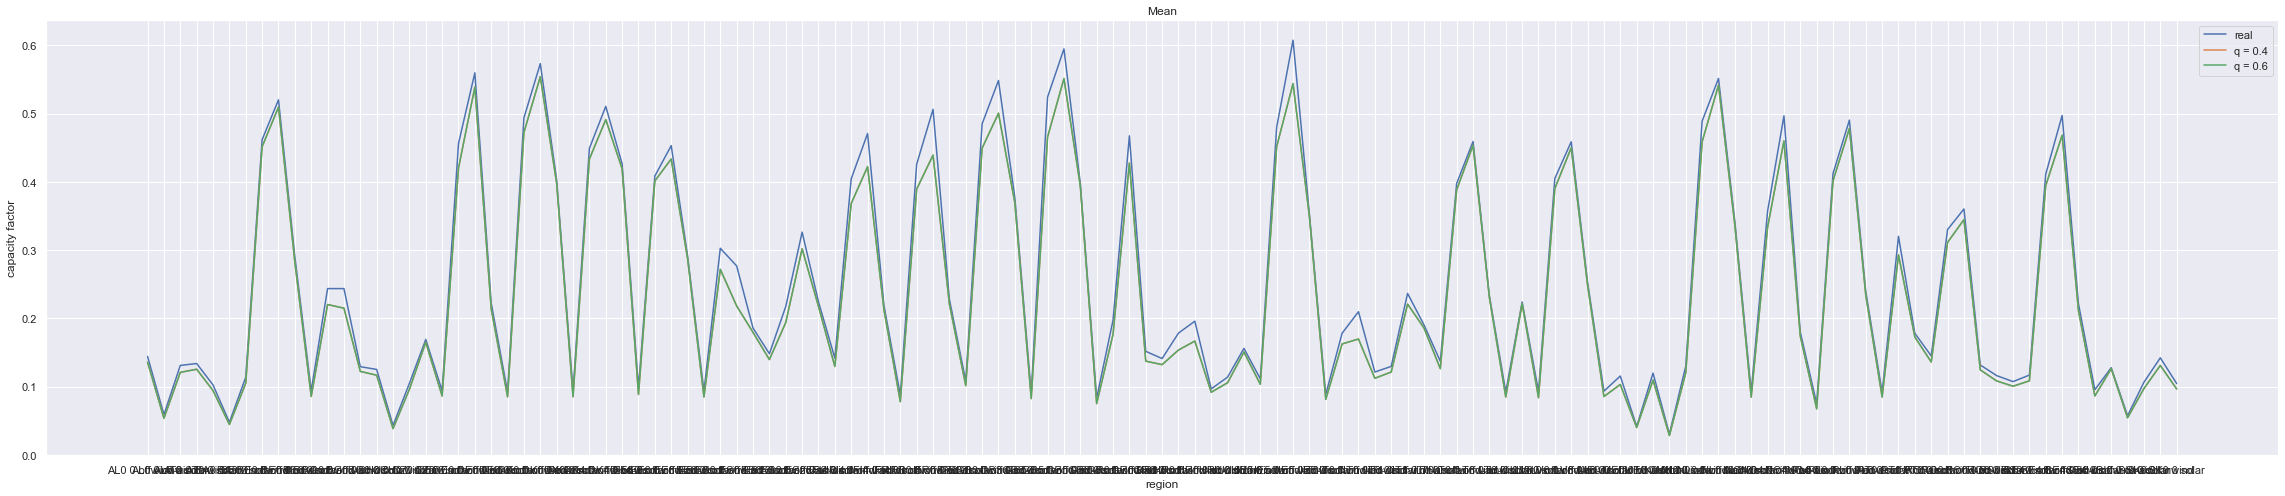

In [50]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis["real_mean"], label="real")
plt.plot(capfacts_analysis["q40_mean"], label="q = 0.4")
plt.plot(capfacts_analysis["q60_mean"], label="q = 0.6")
plt.xlabel("region")
plt.ylabel("capacity factor")
plt.title("Mean")
plt.legend()
plt.savefig("results/capfacts_mean.png")

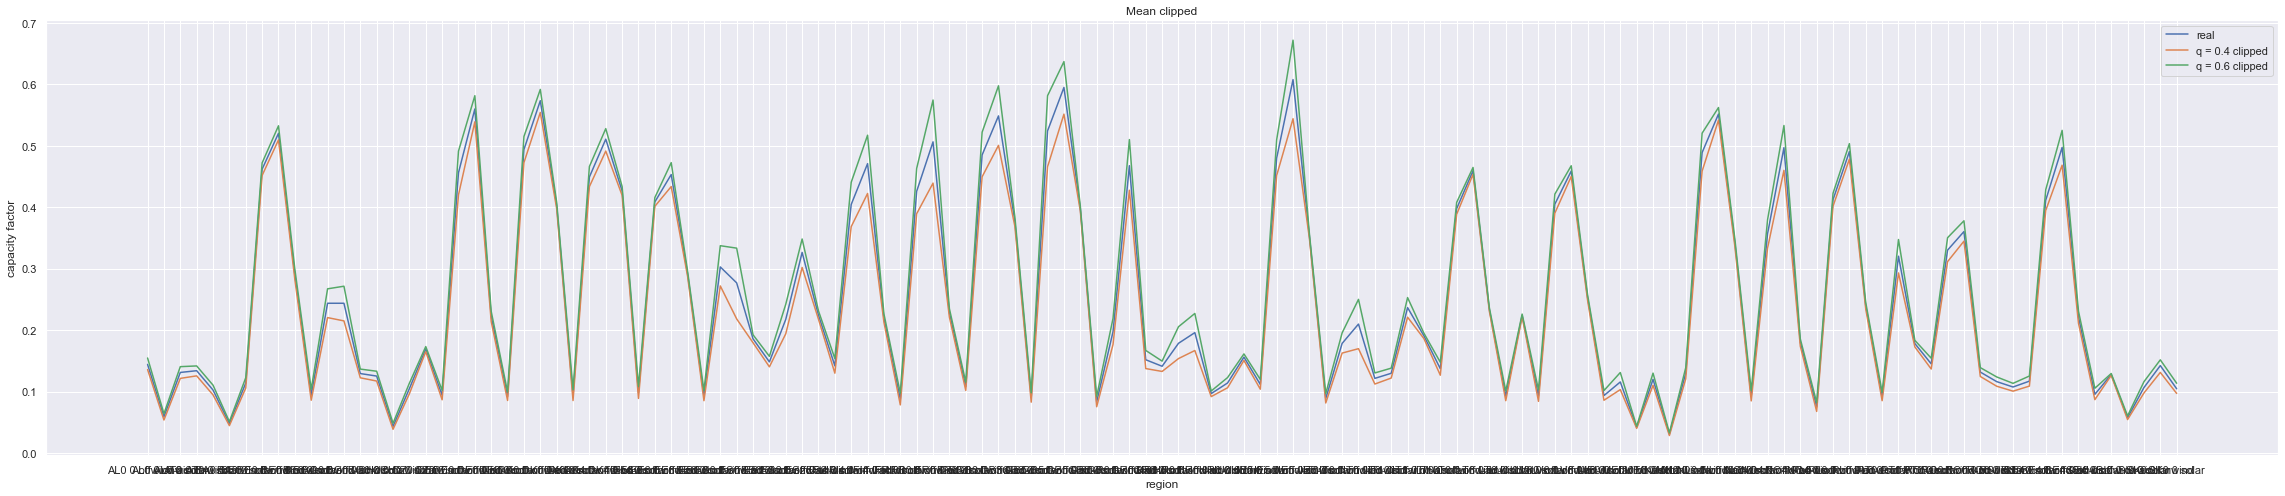

In [52]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis["real_mean"], label="real")
plt.plot(capfacts_analysis["q40_clipped_mean"], label="q = 0.4 clipped")
plt.plot(capfacts_analysis["q60_clipped_mean"], label="q = 0.6 clipped")
plt.xlabel("region")
plt.ylabel("capacity factor")
plt.title("Mean clipped")
plt.legend()
plt.savefig("results/capfacts_clipped_mean.png")

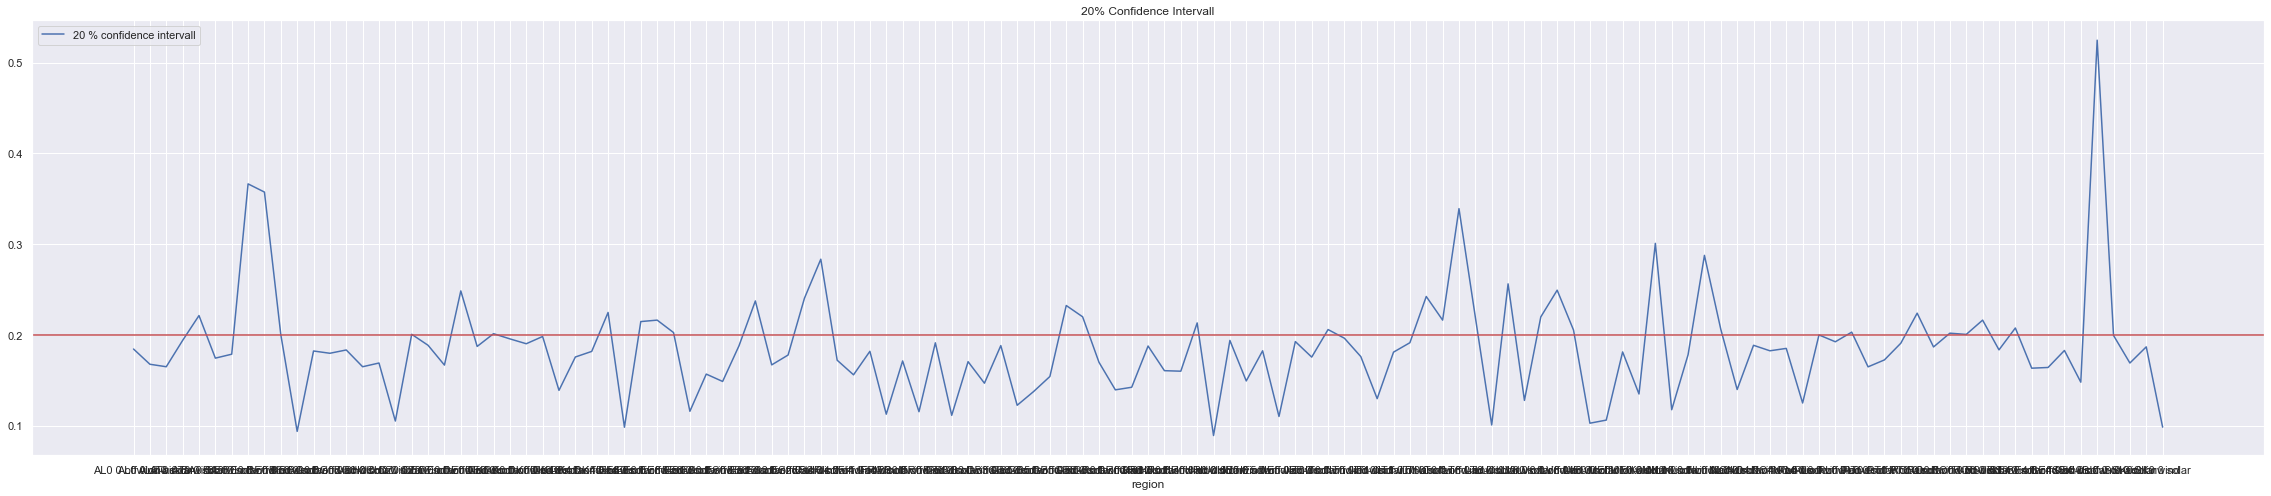

In [55]:
plt.figure(figsize=(40,8))
plt.plot(capfacts_analysis["20% confidence"], label="20 % confidence intervall")
plt.axhline(y=0.2, color='r', linestyle='-')
plt.xlabel("region")
plt.ylabel("")
plt.title("20% Confidence Intervall")
plt.legend()
plt.savefig("results/20p_confidence.png")

## Pypsa

In [58]:
no = pypsa.Network(paths["res_pypsa_qo"])
n4 = pypsa.Network(paths["res_pypsa_q40"])
n6 = pypsa.Network(paths["res_pypsa_q60"])

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 19, 2].

INFO:pypsa.io:Imported network elec_s_37_qo_ec_lv1.0_Co2L0.0-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 19, 2].

INFO:pypsa.io:Imported network elec_s_37_q40_ec_lv1.0_Co2L0.0-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the relea

In [59]:
def get_result(n):
    RE = ['solar','onwind','offwind-ac','offwind-dc']
    result = n.generators.groupby("carrier").sum().p_nom_opt
    result["offwind"] = result["offwind-ac"]+result["offwind-dc"]

    RE = ['solar','onwind','offwind']
    result = result[RE]
    result.index = ['solar','onshore wind','offshore wind']

    return result

In [60]:
result_o = get_result(no)/1e3
result_4 = get_result(n4)/1e3
result_6 = get_result(n6)/1e3

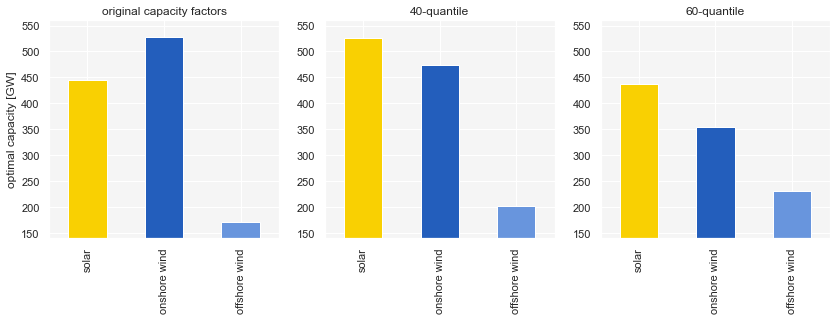

In [61]:
fig, ax = plt.subplots(1,3, figsize=(14,4))

for ax_i in [ax[0], ax[1], ax[2]]:
    ax_i.set_facecolor("whitesmoke")
    ax_i.set_ylim([140, 560])

RE = ['solar','onwind','offwind-ac']
result_o.plot.bar(color=no.carriers.loc[RE].color, ax=ax[0])
result_4.plot.bar(color=no.carriers.loc[RE].color, ax=ax[1])
result_6.plot.bar(color=no.carriers.loc[RE].color, ax=ax[2])

ax[0].set_ylabel("optimal capacity [GW]")

ax[0].set_title("original capacity factors")
ax[1].set_title("40-quantile")
ax[2].set_title("60-quantile")

plt.show()

In [62]:
abs(result_4-result_o)/result_o*100

solar            18.072120
onshore wind     10.241442
offshore wind    17.816610
Name: p_nom_opt, dtype: float64

In [63]:
abs(result_6-result_o)/result_o*100

solar             1.766353
onshore wind     33.066228
offshore wind    35.447407
Name: p_nom_opt, dtype: float64

In [64]:
print(n4.generators_t.p_max_pu.filter(like="solar").sum().sum(),
      n6.generators_t.p_max_pu.filter(like="solar").sum().sum(),
      no.generators_t.p_max_pu.filter(like="solar").sum().sum())

32191.693122129484 37576.53554958304 34984.81538676607


In [65]:

print(n4.generators_t.p_max_pu.filter(like="onwind").sum().sum(),
      n6.generators_t.p_max_pu.filter(like="onwind").sum().sum(),
      no.generators_t.p_max_pu.filter(like="onwind").sum().sum())

61883.875134777045 65723.43816326819 63855.676809046476


In [66]:
print(n4.generators_t.p_max_pu.filter(like="offwind").sum().sum(),
      n6.generators_t.p_max_pu.filter(like="offwind").sum().sum(),
      no.generators_t.p_max_pu.filter(like="offwind").sum().sum())

150151.3300950963 169645.26593223 159806.78293674166


### Available Data

(<matplotlib.collections.PatchCollection at 0x2b22e5be4a0>,
 <matplotlib.collections.LineCollection at 0x2b22e57f610>)

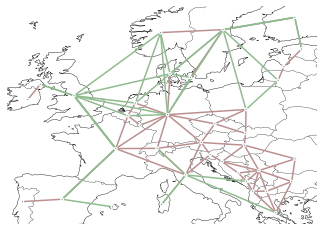

In [136]:
no.plot()

### Generators

- **p_max_pu**: per unit limit, given the weather potentials at the site
- **p_nom**: nominal power
- **p_nom\*p_max_pu** limits maximum possible power
- **p_nom_opt**: optimal capacities for generators

Generators attach to a single bus and can feed in power. It converts energy from its carrier to the carrier-type of the bus to which it is attached.

In [133]:
print(no.all_components)
no.components["Generator"]["attrs"]


{'LineType', 'TransformerType', 'SubNetwork', 'StorageUnit', 'GlobalConstraint', 'Bus', 'Load', 'Carrier', 'Transformer', 'Generator', 'Store', 'ShuntImpedance', 'Link', 'Line'}


,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
bus,string,NaN,,name of bus to which generator is attached,Input (required),True,False,<class 'str'>,object
control,string,NaN,PQ,"P,Q,V control strategy for PF, must be ""PQ"", ""...",Input (optional),True,False,<class 'str'>,object
type,string,NaN,,Placeholder for generator type. Not yet implem...,Input (optional),True,False,<class 'str'>,object
p_nom,float,MW,0.0,Nominal power for limits in OPF.,Input (optional),True,False,<class 'float'>,float64
p_nom_extendable,boolean,NaN,False,Switch to allow capacity p_nom to be extended ...,Input (optional),True,False,<class 'bool'>,bool
p_nom_min,float,MW,0.0,"If p_nom is extendable in OPF, set its minimum...",Input (optional),True,False,<class 'float'>,float64
p_nom_max,float,MW,inf,"If p_nom is extendable in OPF, set its maximum...",Input (optional),True,False,<class 'float'>,float64
p_min_pu,static or series,per unit,0.0,The minimum output for each snapshot per unit ...,Input (optional),True,True,<class 'float'>,float64


In [99]:
no.generators

,p_nom_max,weight,p_nom,capital_cost,p_nom_min,marginal_cost,efficiency,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
AL1 0 offwind-ac,3.365876e+03,342.415672,0.000000,198260.851528,0.000000,0.025517,1.000,AL1 0,offwind-ac,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 oil,inf,0.000000,89.854543,38234.561404,89.854543,130.235920,0.393,AL1 0,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 onwind,6.033723e+04,1422.005376,0.000000,109295.569252,0.000000,0.025056,1.000,AL1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 ror,inf,48.200000,48.200000,270940.715283,0.000000,0.010623,0.900,AL1 0,ror,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
AL1 0 solar,2.099418e+04,3227.580730,16.850000,55064.071419,16.850000,0.019365,1.000,AL1 0,solar,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK1 0 lignite,inf,0.000000,285.863362,142513.708310,285.863362,13.498231,0.447,SK1 0,lignite,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 nuclear,inf,0.000000,1940.000000,440997.425969,1940.000000,16.911082,0.337,SK1 0,nuclear,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SK1 0 onwind,5.097085e+04,6571.909550,3.893693,109295.569252,3.893693,0.024622,1.000,SK1 0,onwind,True,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [119]:
# no.generators_t.p_max_pu
no.generators_t.p_set

Generator
snapshot
2013-01-01 00:00:00
2013-01-01 01:00:00
2013-01-01 02:00:00
2013-01-01 03:00:00
2013-01-01 04:00:00
...
2013-12-31 19:00:00
2013-12-31 20:00:00
2013-12-31 21:00:00


In [91]:
no.buses
no.buses.index.values

array(['AL1 0', 'AT1 0', 'BA1 0', 'BE1 0', 'BG1 0', 'CH1 0', 'CZ1 0',
       'DE1 0', 'DK1 0', 'DK2 0', 'EE6 0', 'ES1 0', 'ES4 0', 'FI2 0',
       'FR1 0', 'GB0 0', 'GB5 0', 'GR1 0', 'HR1 0', 'HU1 0', 'IE5 0',
       'IT1 0', 'IT3 0', 'LT6 0', 'LU1 0', 'LV6 0', 'ME1 0', 'MK1 0',
       'NL1 0', 'NO2 0', 'PL1 0', 'PT1 0', 'RO1 0', 'RS1 0', 'SE2 0',
       'SI1 0', 'SK1 0', 'AL1 0 H2', 'AT1 0 H2', 'BA1 0 H2', 'BE1 0 H2',
       'BG1 0 H2', 'CH1 0 H2', 'CZ1 0 H2', 'DE1 0 H2', 'DK1 0 H2',
       'DK2 0 H2', 'EE6 0 H2', 'ES1 0 H2', 'ES4 0 H2', 'FI2 0 H2',
       'FR1 0 H2', 'GB0 0 H2', 'GB5 0 H2', 'GR1 0 H2', 'HR1 0 H2',
       'HU1 0 H2', 'IE5 0 H2', 'IT1 0 H2', 'IT3 0 H2', 'LT6 0 H2',
       'LU1 0 H2', 'LV6 0 H2', 'ME1 0 H2', 'MK1 0 H2', 'NL1 0 H2',
       'NO2 0 H2', 'PL1 0 H2', 'PT1 0 H2', 'RO1 0 H2', 'RS1 0 H2',
       'SE2 0 H2', 'SI1 0 H2', 'SK1 0 H2', 'AL1 0 battery',
       'AT1 0 battery', 'BA1 0 battery', 'BE1 0 battery', 'BG1 0 battery',
       'CH1 0 battery', 'CZ1 0 battery',

In [92]:
no.loads

,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
AL1 0,AL1 0,,,0.0,0.0,-1.0
AT1 0,AT1 0,,,0.0,0.0,-1.0
BA1 0,BA1 0,,,0.0,0.0,-1.0
BE1 0,BE1 0,,,0.0,0.0,-1.0
BG1 0,BG1 0,,,0.0,0.0,-1.0
CH1 0,CH1 0,,,0.0,0.0,-1.0
CZ1 0,CZ1 0,,,0.0,0.0,-1.0
DE1 0,DE1 0,,,0.0,0.0,-1.0
DK1 0,DK1 0,,,0.0,0.0,-1.0


In [94]:
no.lines

,bus0,bus1,num_parallel,length,type,s_max_pu,s_nom,capital_cost,x,r,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
1,AL1 0,GR1 0,1.000000,474.029281,Al/St 240/40 4-bundle 380.0,0.7,1698.102612,18062.457827,116.611203,14.220878,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,AL1 0,ME1 0,1.335180,186.359938,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,7100.654512,34.335852,4.187299,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,AL1 0,MK1 0,0.000000,175.650433,Al/St 240/40 4-bundle 380.0,0.7,0.000000,6694.467720,inf,inf,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,AL1 0,RS1 0,1.335180,359.657249,Al/St 240/40 4-bundle 380.0,0.7,2267.272739,13707.363978,66.264983,8.081095,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,AT1 0,CH1 0,4.000000,518.769048,Al/St 240/40 4-bundle 380.0,0.7,6792.410447,19771.693455,31.904296,3.890768,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,AT1 0,CZ1 0,2.670360,351.938283,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,13412.361706,32.421402,3.953829,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,AT1 0,DE1 0,9.675900,603.496124,Al/St 240/40 4-bundle 380.0,0.7,16430.671531,22993.731701,15.343280,1.871132,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,AT1 0,HU1 0,2.670360,498.481213,Al/St 240/40 4-bundle 380.0,0.7,4534.545478,18994.726745,45.921289,5.600157,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,AT1 0,IT1 0,0.335180,581.217845,Al/St 240/40 4-bundle 380.0,0.7,569.170127,22146.337436,426.575471,52.021399,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [103]:
print(no.objective + no.objective_constant)
print(n4.objective + n4.objective_constant)
print(n6.objective + n6.objective_constant)

166332544386.2526
170599711237.95563
151479372612.50378


array(['AL1 0', 'AT1 0', 'BA1 0', 'BE1 0', 'BG1 0', 'CH1 0', 'CZ1 0',
       'DE1 0', 'DK1 0', 'DK2 0', 'EE6 0', 'ES1 0', 'ES4 0', 'FI2 0',
       'FR1 0', 'GB0 0', 'GB5 0', 'GR1 0', 'HR1 0', 'HU1 0', 'IE5 0',
       'IT1 0', 'IT3 0', 'LT6 0', 'LU1 0', 'LV6 0', 'ME1 0', 'MK1 0',
       'NL1 0', 'NO2 0', 'PL1 0', 'PT1 0', 'RO1 0', 'RS1 0', 'SE2 0',
       'SI1 0', 'SK1 0', 'AL1 0 H2', 'AT1 0 H2', 'BA1 0 H2', 'BE1 0 H2',
       'BG1 0 H2', 'CH1 0 H2', 'CZ1 0 H2', 'DE1 0 H2', 'DK1 0 H2',
       'DK2 0 H2', 'EE6 0 H2', 'ES1 0 H2', 'ES4 0 H2', 'FI2 0 H2',
       'FR1 0 H2', 'GB0 0 H2', 'GB5 0 H2', 'GR1 0 H2', 'HR1 0 H2',
       'HU1 0 H2', 'IE5 0 H2', 'IT1 0 H2', 'IT3 0 H2', 'LT6 0 H2',
       'LU1 0 H2', 'LV6 0 H2', 'ME1 0 H2', 'MK1 0 H2', 'NL1 0 H2',
       'NO2 0 H2', 'PL1 0 H2', 'PT1 0 H2', 'RO1 0 H2', 'RS1 0 H2',
       'SE2 0 H2', 'SI1 0 H2', 'SK1 0 H2', 'AL1 0 battery',
       'AT1 0 battery', 'BA1 0 battery', 'BE1 0 battery', 'BG1 0 battery',
       'CH1 0 battery', 'CZ1 0 battery',

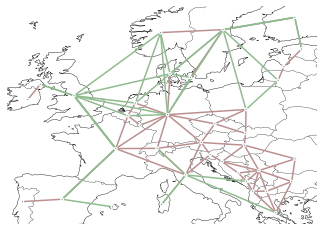

In [87]:
n4.plot()
n4.generators
n4.buses.index.values

,v_nom,x,y,country,control,generator,carrier,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,
AL1 0,380.0,19.897914,41.587568,AL,Slack,AL1 0 offwind-ac,AC,,None,1.0,0.0,inf,
AT1 0,380.0,13.604274,47.549498,AT,PQ,,AC,,None,1.0,0.0,inf,
BA1 0,380.0,18.122704,43.811367,BA,PQ,,AC,,None,1.0,0.0,inf,
BE1 0,380.0,4.617461,50.818887,BE,PQ,,AC,,None,1.0,0.0,inf,
BG1 0,380.0,24.673671,42.765271,BG,PQ,,AC,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RO1 0 battery,1.0,25.091770,45.551309,RO,Slack,,battery,,None,1.0,0.0,inf,
RS1 0 battery,1.0,20.662692,44.113710,RS,Slack,,battery,,None,1.0,0.0,inf,
SE2 0 battery,1.0,16.277634,61.357761,SE,Slack,,battery,,None,1.0,0.0,inf,


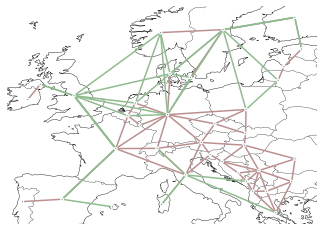

In [82]:
n6.plot()
n6.generators
n6.buses

In [104]:
n4.generators_t.p_max_pu

Generator,AL1 0 offwind-ac,AL1 0 onwind,AL1 0 ror,AL1 0 solar,AT1 0 onwind,AT1 0 ror,AT1 0 solar,BA1 0 onwind,BA1 0 solar,BE1 0 offwind-ac,...,SE2 0 onwind,SE2 0 ror,SE2 0 solar,SI1 0 offwind-ac,SI1 0 onwind,SI1 0 ror,SI1 0 solar,SK1 0 onwind,SK1 0 ror,SK1 0 solar
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.018007,0.287988,0.0,0.175266,0.319752,0.0,0.000000,0.0,0.982549,...,0.384801,0.614558,0.0,0.000000,0.014418,0.361519,0.0,0.236736,0.085513,0.0
2013-01-01 01:00:00,0.000000,0.010318,0.287961,0.0,0.175266,0.319629,0.0,0.000000,0.0,0.968969,...,0.384801,0.613134,0.0,0.000000,0.019600,0.361493,0.0,0.236736,0.085364,0.0
2013-01-01 02:00:00,0.000000,0.000000,0.287951,0.0,0.152724,0.319530,0.0,0.000000,0.0,0.935869,...,0.385571,0.612455,0.0,0.000000,0.025477,0.361420,0.0,0.262676,0.085328,0.0
2013-01-01 03:00:00,0.000000,0.000000,0.288079,0.0,0.137218,0.319457,0.0,0.000000,0.0,0.831915,...,0.385571,0.611459,0.0,0.000000,0.036631,0.361440,0.0,0.262676,0.085528,0.0
2013-01-01 04:00:00,0.000000,0.000000,0.288156,0.0,0.130751,0.319406,0.0,0.010373,0.0,0.647624,...,0.384801,0.610764,0.0,0.000000,0.041897,0.361415,0.0,0.264466,0.085647,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.029159,0.052332,0.262415,0.0,0.111254,0.392258,0.0,0.000000,0.0,0.918328,...,0.308273,0.460301,0.0,0.025981,0.000000,0.696073,0.0,0.074543,0.127008,0.0
2013-12-31 20:00:00,0.029166,0.065333,0.262311,0.0,0.129625,0.391981,0.0,0.000000,0.0,0.774481,...,0.284335,0.460113,0.0,0.021932,0.000000,0.695379,0.0,0.082564,0.127079,0.0
2013-12-31 21:00:00,0.029159,0.070563,0.262316,0.0,0.129625,0.391720,0.0,0.000000,0.0,0.706745,...,0.250199,0.459930,0.0,0.000000,0.000000,0.694663,0.0,0.083678,0.127145,0.0


In [141]:
q4 = pd.read_csv("results/capfacts_pred_q40_clipped.csv", index_col=0)
q4

,snapshot,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,BE0 0 offwind-dc,...,RS0 0 solar,SE4 0 offwind-ac,SE4 0 offwind-dc,SE4 0 onwind,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 solar,SK0 0 onwind,SK0 0 solar
0,2013-01-01 00:00:00,0.000935,0.018007,0.000974,0.175266,0.00209,0.007819,0.002167,0.982549,0.994409,...,0.001178,0.881669,0.925296,0.384801,0.000987,0.000000,0.014418,0.001826,0.236736,0.000889
1,2013-01-01 01:00:00,0.000935,0.010318,0.000974,0.175266,0.00209,0.009555,0.001097,0.968969,0.994409,...,0.001178,0.862863,0.925686,0.384801,0.000987,0.000000,0.019600,0.001826,0.236736,0.000889
2,2013-01-01 02:00:00,0.000935,0.004316,0.001258,0.152724,0.00209,0.009555,0.001097,0.935869,0.994381,...,0.001178,0.862863,0.925686,0.385571,0.000987,0.000000,0.025477,0.001826,0.262676,0.000889
3,2013-01-01 03:00:00,0.000935,0.002376,0.002605,0.137218,0.00209,0.009555,0.001097,0.831915,0.935168,...,0.001178,0.862863,0.925686,0.385571,0.000987,0.000000,0.036631,0.001826,0.262676,0.000889
4,2013-01-01 04:00:00,0.000000,0.000000,0.002605,0.130751,0.00209,0.010373,0.001097,0.647624,0.760954,...,0.001178,0.862863,0.925686,0.384801,0.000987,0.000000,0.041897,0.001826,0.264466,0.000889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.029159,0.052332,0.000953,0.111254,0.00209,0.001783,0.000952,0.918328,0.988046,...,0.000879,0.773768,0.856786,0.308273,0.000987,0.025981,0.003609,0.001372,0.074543,0.000955
8756,2013-12-31 20:00:00,0.029166,0.065333,0.000953,0.129625,0.00209,0.001783,0.000952,0.774481,0.907568,...,0.002752,0.741780,0.850961,0.284335,0.000987,0.021932,0.004997,0.001372,0.082564,0.000955
8757,2013-12-31 21:00:00,0.029159,0.070563,0.001167,0.129625,0.00209,0.001793,0.000952,0.706745,0.846384,...,0.009836,0.692501,0.791599,0.250199,0.000987,0.000000,0.005047,0.001372,0.083678,0.000955
8758,2013-12-31 22:00:00,0.029550,0.052332,0.001167,0.161576,0.00209,0.001991,0.000952,0.771093,0.915945,...,0.000094,0.672184,0.783148,0.204543,0.000987,0.000000,0.008052,0.001372,0.090550,0.000955


In [120]:
# no.buses_t.p # Active Power injection per bus
no.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
CCGT,0.187,#b20101,Combined-Cycle Gas,inf
coal,0.354,#707070,Coal,inf
onwind,0.000,#235ebc,Onshore Wind,inf
oil,0.248,#262626,Oil,inf
offwind-dc,0.000,#74c6f2,Offshore Wind (DC),inf
offwind-ac,0.000,#6895dd,Offshore Wind (AC),inf
biomass,0.000,#0c6013,Biomass,inf
geothermal,0.026,#ba91b1,Geothermal,inf
nuclear,0.000,#ff9000,Nuclear,inf


In [112]:
n4.buses_t.p

Bus,AL1 0,AT1 0,BA1 0,BE1 0,BG1 0,CH1 0,CZ1 0,DE1 0,DK1 0,DK2 0,...,MK1 0 battery,NL1 0 battery,NO2 0 battery,PL1 0 battery,PT1 0 battery,RO1 0 battery,RS1 0 battery,SE2 0 battery,SI1 0 battery,SK1 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-669.116724,-14401.858511,347.720901,661.073358,302.824640,-5116.577204,-6641.733706,16688.646766,-2884.456739,2377.336650,...,1.125006e-08,-2.145272e-08,-2.041169e-08,-2.039984e-08,-2.033795e-08,-1.365962e-08,-1.963335e-09,-2.036780e-08,-8.249866e-08,-2.359595e-08
2013-01-01 01:00:00,-620.290505,-14519.051911,426.897594,1092.952575,525.109941,-4908.848882,-6591.688019,16299.575205,-2884.972362,2377.336646,...,-2.146766e-08,-2.061099e-08,-2.029482e-08,-2.032776e-08,-1.210619e-08,-2.041691e-08,-3.839842e-08,-2.023836e-08,1.757249e-08,-2.084475e-08
2013-01-01 02:00:00,-579.505733,-14588.700670,486.502691,1348.788890,-165.687183,-4593.280122,-6462.265312,15917.023152,-2894.330853,2377.336620,...,-7.458271e-08,-2.121480e-08,-2.043515e-08,-2.027537e-08,-1.611549e-08,-2.610780e-08,-3.657533e-08,-2.043739e-08,-1.214597e-08,-1.749949e-08
2013-01-01 03:00:00,-540.159332,-14479.492560,526.507302,809.545145,-9.116118,-5247.344375,-6384.642525,16707.246769,-2907.351042,2377.336573,...,-3.476902e-09,-1.912048e-08,-2.090286e-08,-2.046579e-08,-2.895463e-08,-1.673968e-08,-6.035135e-09,-2.048562e-08,-1.502118e-08,-2.545723e-08
2013-01-01 04:00:00,-541.274234,-13741.630720,541.396501,-132.743431,25.214764,-9589.117096,-6276.092296,21214.296850,-2896.101685,2377.336652,...,-3.794523e-08,-1.915021e-08,-2.086575e-08,-2.043413e-08,-1.518467e-08,-2.042393e-08,-5.472007e-08,-2.043973e-08,9.136607e-08,-1.034085e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,1176.996361,-13582.548575,348.904119,-633.382561,-1237.083203,-4810.681530,-6198.497840,14302.169290,327.213553,2377.336679,...,2.802083e-08,-2.119963e-08,-2.058675e-08,-2.041403e-08,-1.441726e-08,-2.298441e-08,3.971501e-08,-2.043294e-08,3.424400e-08,2.463391e-09
2013-12-31 20:00:00,756.622437,-13509.590369,378.308620,-1299.388421,-818.818980,-4816.657075,-5983.056714,15499.113840,-633.605994,2377.336679,...,-4.235579e-08,-2.139328e-08,-2.057823e-08,-2.077987e-08,-2.440581e-08,-1.873338e-08,-2.019444e-08,-2.011969e-08,2.090898e-07,-6.917177e-09
2013-12-31 21:00:00,341.116345,-13475.564531,414.983051,-2263.281619,-749.103264,-4817.748486,-5880.970066,14403.599124,733.673514,2377.336682,...,-1.813299e-08,-1.993101e-08,-2.056459e-08,-2.056375e-08,-7.245645e-09,-1.803118e-08,4.090509e-08,-2.065417e-08,6.895873e-08,-1.513975e-08


In [138]:
no.sub_networks_t

{}

In [ ]:
# no.determine_network_topology()